In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import dill

from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Activation, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential
from keras import layers

import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [2]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Define Helper Functions**

In [3]:
#Cleans Text
def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    tokens = nltk.word_tokenize(only_letters)[2 :]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return filtered_result

#Generate Plots for Model
def plot_graphs(history, metric):
  plt.figure( figsize=(16,12))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history[metric])
  #plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#make a prediction on input text
def predict_on_text(text):
  
  test_text = np.array([text])
  test_df =  pd.DataFrame(test_text, columns = ['text'])

  test_df['normalized_tweet'] = test_df.text.apply(normalizer)
  X = test_df["normalized_tweet"].astype(str)

  df = token.texts_to_sequences(X)

  df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)

  prediction = np.round(model.predict(df)[0][0])

  if prediction:

    return "This is about Sports."

  else:

    return "This is not about Sports."

# compute accuracy
def accuracy(y, y_hat):

  acc = np.mean(y == y_hat)

  print('The accuracy is: ' + str(acc))

#generates confusion matrix
def confusionMatrix(ys,preds):
    
    N = len(ys)
    #Generate empty matrix
    confuse = np.zeros((2,2),dtype=int)
    
    #loop through both arrays
    for i in range(N):
    
      #increase count in entry of each label
      confuse[ys[i],int(preds[i])] = confuse[ys[i],int(preds[i])] + 1
    
    #return as dataframe
    return pd.DataFrame(confuse)

**Data Reading and Cleaning**

The first label is a bad to good scale 1: Awful 2:Bad 3: Neutral 4:Good 5:Great . 

Priority is currently on a scale of 1- 4 with one being the least urgent. 

Type of tweet is about content 0: nonsense , 1: personal comments 2: news 3: religious 4: reviews 5: jokes and references 6: clickbait and soft news 7: advertisements 8: personal anecdotes 9: Talk about celeberties, movies ,etc 10: Questions 11: Sports

In [4]:
#If you get any encode decode error while reading the csv file. So, determine the what type
# of character is encoding 

import chardet
file = "/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/600triple_labeled_tweets.csv"
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.7251294678316124, 'language': ''}

In [5]:
#uploaded = files.upload()

df = pd.read_csv(file,encoding='ISO-8859-1')

#map data labels to 0 or 1 
# df.label = df["label"].replace({"not_sports":0,"sports":1})

#add cleaned data to the DataFrame
df['Normalized_text'] = df.Text.apply(normalizer)

#seperate X and y out as DataFrames
X = df["Normalized_text"].astype(str)
y = df["Priority"]

In [6]:
df.head()

,Text,Good,Priority,Type,Normalized_text
0,*screams in 25 different languages*,3,1,5,"[different, languages]"
1,Families to sue over Legionnaires: More than 4...,2,2,2,"[sue, legionnaires, families, affected, fatal,..."
2,Pandemonium In Aba As Woman Delivers Baby With...,2,1,6,"[aba, woman, delivers, baby, without, face, ph..."
3,My emotions are a train wreck. My body is a tr...,2,1,9,"[train, wreck, body, train, wreck, wreck]"
4,Alton brown just did a livestream and he burne...,4,1,1,"[livestream, burned, butter, touched, hot, pla..."


In [7]:
max_features = 50000 #we set maximum number of words to 5000
max_length = 200 #we set maximum sequence length to 400
embedding_dim = 100 

token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features) 
token.fit_on_texts(X)

vocab_size = len(token.word_index) + 1 

#conver X to a TensorFlow Type and add padding
df = token.texts_to_sequences(X)
df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)

**Split data into Train and Text**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y,test_size=0.15,random_state=101)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

**Model Architecture**

In [9]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_length))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid',kernel_initializer='uniform'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          280800    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 281,821
Trainable params: 281,821
Non-trainable params: 0
_________________________________________________________________


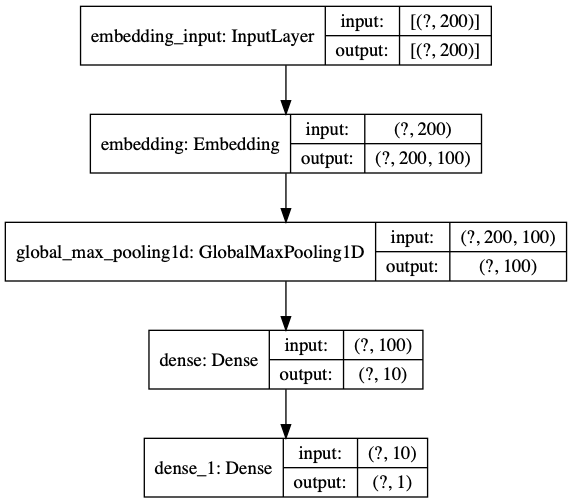

In [10]:
import keras.utils.vis_utils
from keras.utils.vis_utils import plot_model    

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(model, to_file='model.png')
keras.utils.plot_model(model, show_shapes=True)

**Load and Train the model**

In [11]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=64,epochs=15) 

Epoch 1/15
8/8 [==============================] - 0s 9ms/step - loss: 0.6906 - accuracy: 0.5730
Epoch 2/15
8/8 [==============================] - 0s 10ms/step - loss: 0.6789 - accuracy: 0.7908
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.79 - 0s 11ms/step - loss: 0.6653 - accuracy: 0.7908
Epoch 4/15
8/8 [==============================] - 0s 11ms/step - loss: 0.6475 - accuracy: 0.7908
Epoch 5/15
8/8 [==============================] - 0s 11ms/step - loss: 0.6212 - accuracy: 0.7908
Epoch 6/15
8/8 [==============================] - 0s 10ms/step - loss: 0.5866 - accuracy: 0.7908
Epoch 7/15
8/8 [==============================] - 0s 11ms/step - loss: 0.5389 - accuracy: 0.7908
Epoch 8/15
8/8 [==============================] - 0s 13ms/step - loss: 0.4759 - accuracy: 0.7908
Epoch 9/15
8/8 [==============================] - 0s 10ms/step - loss: 0.3982 - accuracy: 0.7908
Epoch 10/15
8/8 [==============================] - 0s 10ms/step - loss: 0.3003 - accur

In [12]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 2ms/step - loss: -0.4615 - accuracy: 0.8000


[-0.46151965856552124, 0.800000011920929]

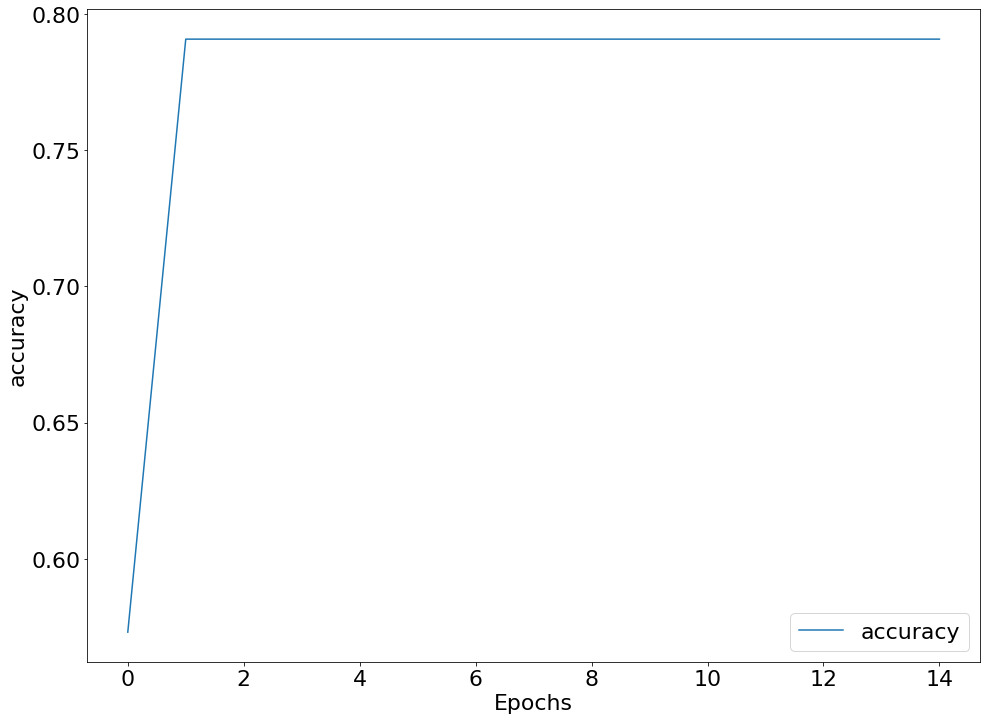

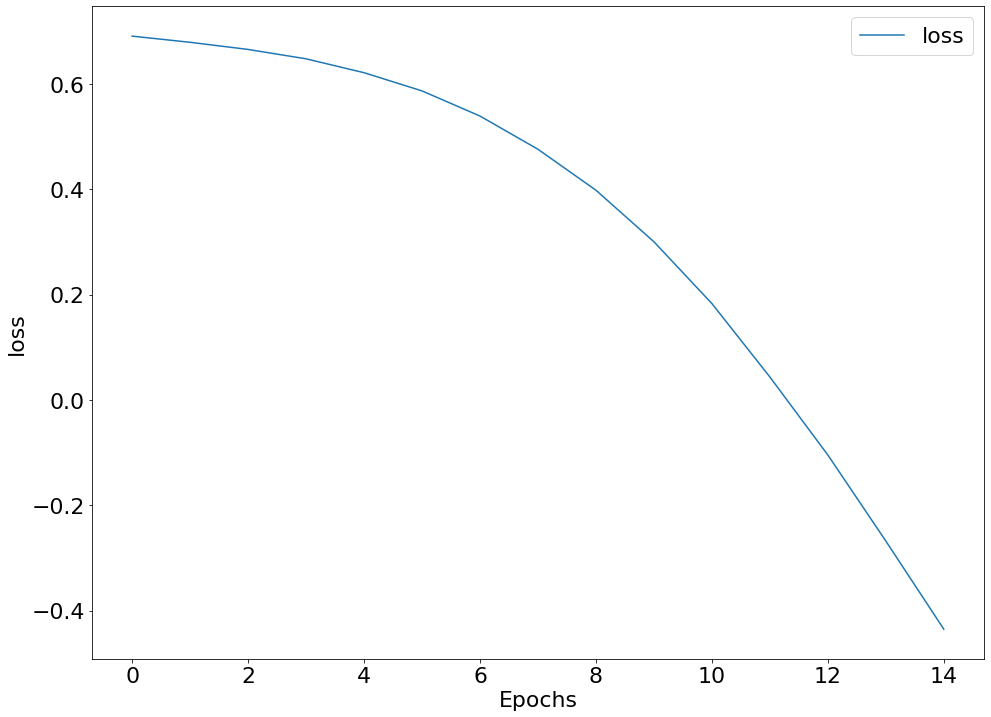

In [13]:
#plot graphs for training
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')